# Building a Report Writing Agentic System using Reflection
Build a report writing agent that utilizes reflection to iteratively improve its output. By getting feedback, the agent can critique its own work and refine it in subsequent iterations, leading to a higher-quality final report.

This approach is inspired by the concept of reflection in LLM agent building, where the agent observes its past outputs and assesses the quality of its actions to enhance future performance.

### Overview
Our report writing agent will:

1. Generate an initial report based on a user-provided topic.
2. Reflect on the generated report by critiquing its content, structure, and style.
3. Iterate the process by incorporating the reflections to improve the report.
4. Repeat the reflection and revision steps for a set number of iterations or until the report meets a desired quality threshold.

### Imports and Setup
We start by importing the necessary libraries and setting up the environment:



In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
import os

from typing import Annotated, List, Optional
from typing_extensions import TypedDict

from dotenv import load_dotenv

_ = load_dotenv()

### Defining the Models
One interesting thing we can do in multi agent systems is to use different models for different agents. 

We use the `gpt-oss-20b:free` model from OpenAI for the report generation and the `nvidia/nemotron-nano-9b-v2:free` model from OpenAI for the reflection steps. 

The `gpt-oss-20b:free` model is faster than the `gpt-oss-120b:free` model, so it is a good choice for the report generation step, while the `nvidia/nemotron-nano-9b-v2:free` model is more accurate and capable for the reflection step.

In [2]:
# Report Generation Model
generation_llm = ChatOpenAI(
    model="openai/gpt-oss-20b:free",  
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature = 0.3,
    max_tokens = 4000  # Increased to prevent truncation of longer reports
)

# Reflection Model
reflection_llm =  ChatOpenAI(
    model="nvidia/nemotron-nano-9b-v2:free",  
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    temperature = 0,
    max_tokens = 2000  # Increased to allow for comprehensive feedback
)

In [3]:
# Tavily Search Tool
tavily_search = TavilySearch(max_results=5)

# List of tools for the agent
tools = [tavily_search]

In [4]:
generation_llm_with_tools = generation_llm.bind_tools(tools)

In [5]:
reflection_llm_with_tools = reflection_llm.bind_tools(tools)

### Defining the Report Generation Step
We create a chain for generating the initial report:

In [6]:
# Prompt for Report Generation
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional report writer specializing in comprehensive and informative reports."
            " Generate a detailed, complete report based on the user's topic. Ensure the report is fully complete with all sections finished."
            " The report should be comprehensive and well-structured, typically between 800-1500 words."
            " IMPORTANT: Always complete the entire report - do not leave any sections unfinished or cut off mid-sentence."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Bind the prompt to the LLM
generate_report = generation_prompt | generation_llm_with_tools


### Defining the Reflection Step
We create a prompt template for reflecting on and critiquing the generated report:

In [7]:
# Prompt for Reflection
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert reviewer tasked with critiquing and providing detailed feedback on reports."
            " Analyze the report for content accuracy, structure, depth, and style."
            " Provide constructive feedback and suggestions for improvement if any."
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Bind the prompt to the LLM
reflect_on_report = reflection_prompt | reflection_llm_with_tools


### Defining the State
We define the state that will be passed through the LangGraph nodes:

In [8]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    last_node: Optional[str]  # Track which node called tools


### Building the Graph
We create nodes for generation, reflection, and a loop to iterate over the process:


In [9]:
# Initialize the graph builder
builder = StateGraph(State)

# Generation Node
async def generation_node(state: State) -> State:
    result = await generate_report.ainvoke(state["messages"])
    return {
        "messages": [result],
        "last_node": "generate"  # Track that generate is the current node
    }

builder.add_node("generate", generation_node)

# Reflection Node
async def reflection_node(state: State) -> State:
    # Swap message roles for reflection, but preserve ToolMessages
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) 
        if hasattr(msg, "type") and msg.type in cls_map
        else msg  # Preserve ToolMessage and other message types
        for msg in state["messages"][1:]
    ]
    res = await reflect_on_report.ainvoke(translated)
    # Treat reflection as human feedback
    return {
        "messages": [HumanMessage(content=res.content)],
        "last_node": "reflect"  # Track that reflect is the current node
    }

builder.add_node("reflect", reflection_node)
tool_node = ToolNode(tools = tools)
builder.add_node("tools", tool_node)

# Set the entry point of the graph
builder.set_entry_point("generate")

# Custom routing function that checks for tools first, then decides on continuation
def route_after_generate(state: State):
    # Check if the last message has tool calls
    if state["messages"] and hasattr(state["messages"][-1], "tool_calls") and state["messages"][-1].tool_calls:
        return "tools"
    # If no tools needed, check if we should continue
    # Count only non-tool messages to avoid ending too early due to tool message spam
    non_tool_messages = [msg for msg in state["messages"] if not isinstance(msg, ToolMessage)]
    if len(non_tool_messages) > 15:  # Increased limit to allow for complete reports with multiple iterations
        return END
    return "reflect"

def route_after_reflect(state: State):
    # Check if the last message has tool calls
    if state["messages"] and hasattr(state["messages"][-1], "tool_calls") and state["messages"][-1].tool_calls:
        return "tools"
    # If no tools needed, go back to generate
    return "generate"

def route_after_tools(state: State):
    # Route back to the node that called the tools
    last_node = state.get("last_node", "generate")
    if last_node == "reflect":
        return "reflect"
    else:
        return "generate"



# Add conditional edges
builder.add_conditional_edges(
    "generate", 
    route_after_generate,
    {
        "tools": "tools",
        "reflect": "reflect",
        END: END
    }
)

builder.add_conditional_edges(
    "reflect",
    route_after_reflect,
    {
        "tools": "tools",
        "generate": "generate"
    }
)

# After tools, route back to the node that called them
builder.add_conditional_edges(
    "tools",
    route_after_tools,
    {
        "generate": "generate",
        "reflect": "reflect"
    }
)

# Compile the graph with memory checkpointing
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


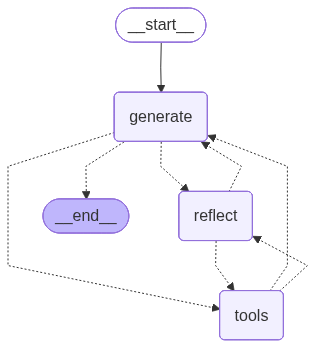

In [10]:
from IPython.display import display, Image

# Visualize the chatbot's workflow
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass  # Visualization requires additional dependencies

### Running the Agent
We run the agent with a user-provided topic:


In [11]:
config = {"configurable": {"thread_id": "1"}}
# topic = "Importance of team work in any project work"
topic = "Who is the innovation officer of biosphere 2 and his work for biosphere 2"

In [ ]:
async def run_agent():
    # Store all outputs for full report
    all_reports = []
    all_reflections = []
    
    async for event in graph.astream(
        {
            "messages": [
                HumanMessage(content=topic)
            ],
            "last_node": None  # Initialize last_node
        },
        config,
    ):
        # Debug: print all event keys
        # print(f"Event keys: {list(event.keys())}")
        
        if "generate" in event:
            print("=== Generated Report ===")
            if event["generate"]["messages"]:
                # Get the full content without truncation
                content = event["generate"]["messages"][-1].content
                if content:
                    print(content)
                    all_reports.append(content)
                    # Check if content appears complete
                    if content and not content.strip().endswith(('...', '```', '---')):
                        print(f"\n[Report length: {len(content)} characters]")
                else:
                    print("[No content in message - likely tool calls]")
            print("\n")
        
        if "reflect" in event:
            print("=== Reflection ===")
            if event["reflect"]["messages"]:
                # Get the full content without truncation
                content = event["reflect"]["messages"][-1].content
                if content:
                    print(content)
                    all_reflections.append(content)
                    print(f"\n[Reflection length: {len(content)} characters]")
                else:
                    print("[No content in message]")
            print("\n")
        
        if "tools" in event:
            print(f"[DEBUG] Tools executed: {len(event.get('tools', {}).get('messages', []))} messages\n")
    
    # Save final report to file to avoid truncation
    if all_reports:
        final_report = all_reports[-1]
        with open("final_report.txt", "w", encoding="utf-8") as f:
            f.write(f"Topic: {topic}\n\n")
            f.write("=" * 80 + "\n")
            f.write("FINAL REPORT\n")
            f.write("=" * 80 + "\n\n")
            f.write(final_report)
        print(f"\n{'='*80}")
        print(f"FULL REPORT SAVED TO: final_report.txt")
        print(f"Report length: {len(final_report)} characters")
        print(f"Word count: ~{len(final_report.split())} words")
        print(f"{'='*80}\n")
        
        # Check if report appears complete
        if final_report.strip().endswith(('...', '```', '---')):
            print("⚠️  WARNING: Report may be truncated (ends with incomplete marker)")
        else:
            print("✅ Report appears complete")

import asyncio
await run_agent()


=== Generated Report ===
[No content in message]


[DEBUG] Tools executed: 1 messages

=== Generated Report ===
[No content in message]


[DEBUG] Tools executed: 32 messages

=== Generated Report ===
**Innovation Officer of Biosphere 2: Jeff Larsen**

| Item | Details |
|------|---------|
| **Name** | **Jeff Larsen** |
| **Title** | Innovation Officer, Biosphere 2 |
| **Contact** | Phone: 720‑838‑7806 <br> Email: jefflarsen@arizona.edu |
| **Primary Role** | Acts as the key liaison between Biosphere 2 and a broad spectrum of entrepreneurial partners in both the public and private sectors, fostering collaborations that leverage the facility’s unique capabilities to drive innovation in digital technologies and entrepreneurship. |
| **Key Responsibilities** | • Leads strategic initiatives to advance earth‑science research through artificial intelligence (AI) and digital technologies. <br>• Serves as Product Manager for **Biosphere 3**, an AI‑powered “Science‑as‑a‑Service” platform. <br>• 